In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize

This notebook assesses the error in RACs-based ML models, when using the same training/validation split as the PBE0/SCAN0 models.

In [2]:
#to get the energy errors
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
#rename so that the convention matches the original VSS-452
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

def pred_energy(structure, dataset, functional, pred_hfx):
    #structure is the name of the complex, dataset is whether the structure is from vss or csd, 
    #functional is the functional used
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

def get_energy_error(pred_df, pred_name, functional, dataset):
    errors = []
    if dataset == 'csd':
        df = csd_76
    else:
        df = vss_452
    for idx, row in pred_df.iterrows():
        pred = pred_energy(idx, dataset, functional, row[pred_name])
        errors.append(pred - df.loc[idx]['dlpno-CCSD_T.vertsse'])
    return np.mean(np.abs(np.array(errors)))

# Obtaining Errors

In [3]:
def get_errors(pred_df, csd_pred_df, functional, model, seed):
    name = functional + '-' + model +'-' + str(seed)
    set_name = functional + '-' + model +'-set-' + str(seed)
    train = pred_df[pred_df[set_name] == 'train']
    val = pred_df[pred_df[set_name] == 'val']

    if functional == 'pbe':
        ref = 'hfx_pbe'
    elif functional == 'scan':
        ref = 'hfx_scan'
    else:
        raise ValueError('Provide a functional pbe or scan')
    csd = csd_pred_df[[not np.isnan(x) for x in csd_pred_df[name]]] #remove all structures not in the csd set

    train_hfx_mae = np.mean(np.abs(train[ref] - train[name]))
    val_hfx_mae = np.mean(np.abs(val[ref] - val[name]))
    csd_hfx_mae = np.mean(np.abs(csd[ref] - csd[name]))

    train_energy_mae = get_energy_error(train, name, functional, 'vss')
    val_energy_mae = get_energy_error(val, name, functional, 'vss')
    csd_energy_mae = get_energy_error(csd, name, functional, 'csd')

    return train_hfx_mae, val_hfx_mae, csd_hfx_mae, train_energy_mae, val_energy_mae, csd_energy_mae

def make_parity(pred_df, csd_pred_df, model, seed, functional):
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
    for idx, functional in enumerate([functional]):
        name = functional + '-' + model +'-' + str(seed)
        set_name = functional + '-' + model +'-set-' + str(seed)
        train = pred_df[pred_df[set_name] == 'train']
        val = pred_df[pred_df[set_name] == 'val']
        test = pred_df[pred_df[set_name] == 'test']

        if functional == 'pbe':
            ref = 'hfx_pbe'
        elif functional == 'scan':
            ref = 'hfx_scan'
        csd = csd_pred_df[[not np.isnan(x) for x in csd_pred_df[name]]] #remove all structures not in the csd set
    
        train_hfx_mae, val_hfx_mae, csd_hfx_mae, train_energy_mae, val_energy_mae, csd_energy_mae = \
        get_errors(pred_df, csd_pred_df, functional, model, seed)
        ax[0].scatter(train[ref], train[name], color='#00C440', alpha=0.5)
        ax[0].set_title(f'{functional.upper()} Train')
        ax[1].scatter(val[ref], val[name], color='#FF0000', alpha=0.5)
        ax[1].set_title(f'{functional.upper()} Val')
        ax[2].scatter(csd[ref], csd[name], color='#8c8c8c', alpha=0.5)
        ax[2].set_title(f'{functional.upper()} CSD')
    
        for i in range(3):
            ax[i].set_xlim(-5, 105)
            ax[i].set_ylim(-5, 105)
            ax[i].plot((0, 100), (0, 100), 'k--')
            ax[i].set_xlabel('Optimal HFX%')
            ax[i].set_ylabel('Predicted HFX%')
        
        ax[0].text(0, 85, f'MAE = {train_hfx_mae:1.2f} HFX% \nMAE = {train_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
        ax[1].text(0, 85, f'MAE = {val_hfx_mae:1.2f} HFX% \nMAE = {val_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
        ax[2].text(0, 85, f'MAE = {csd_hfx_mae:1.2f} HFX% \nMAE = {csd_energy_mae:1.2f} kcal/mol', bbox=dict(edgecolor='black', facecolor='white'))
    
        fig.suptitle(f'{model.upper()}, Random Seed {seed}')
        fig.tight_layout()

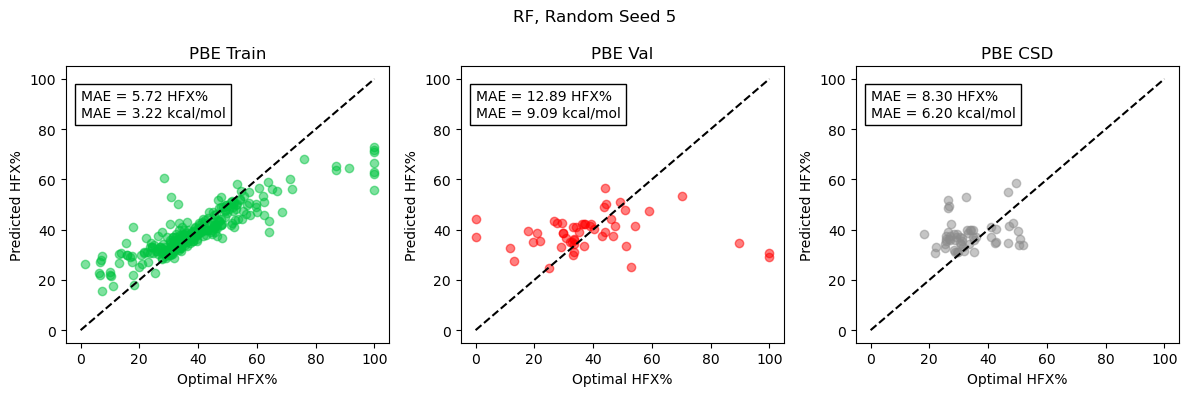

In [4]:
vss_preds = pd.read_csv('racs_replicate_dfbp_set/pbe-vss_racs_predictions.csv').set_index('Unnamed: 0')
csd_preds = pd.read_csv('racs_replicate_dfbp_set/pbe-csd_racs_predictions.csv').set_index('Unnamed: 0')

#restrict targets and predictions between 0 and 100
cols = vss_preds.select_dtypes(include=np.number).columns
vss_preds[cols] = vss_preds[cols].clip(0, 100)

cols = csd_preds.select_dtypes(include=np.number).columns
csd_preds[cols] = csd_preds[cols].clip(0, 100)

make_parity(vss_preds, csd_preds, 'rf', 5, 'pbe')

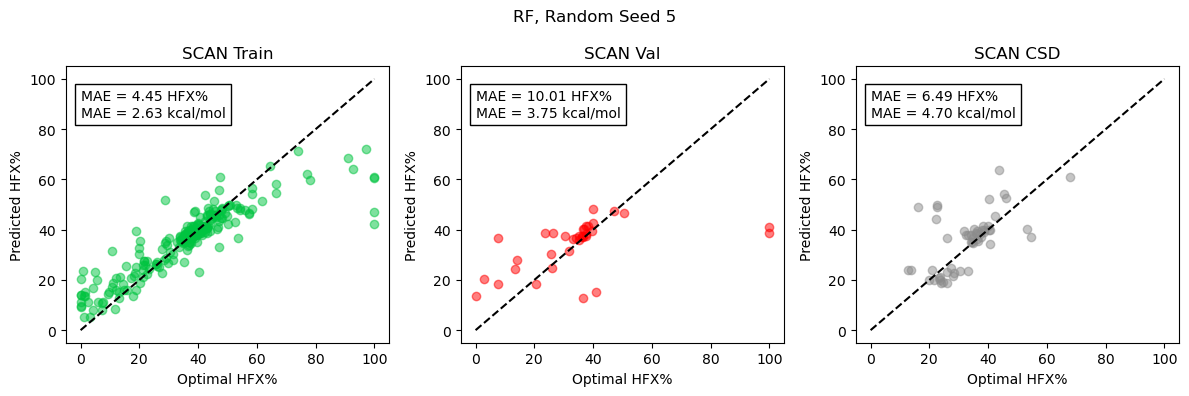

In [5]:
vss_preds = pd.read_csv('racs_replicate_dfbp_set/scan-vss_racs_predictions.csv').set_index('Unnamed: 0')
csd_preds = pd.read_csv('racs_replicate_dfbp_set/scan-csd_racs_predictions.csv').set_index('Unnamed: 0')

#restrict targets and predictions between 0 and 100
cols = vss_preds.select_dtypes(include=np.number).columns
vss_preds[cols] = vss_preds[cols].clip(0, 100)

cols = csd_preds.select_dtypes(include=np.number).columns
csd_preds[cols] = csd_preds[cols].clip(0, 100)

make_parity(vss_preds, csd_preds, 'rf', 5, 'scan')